In [24]:
# Rotate the waveforms from E and N to R and T
%matplotlib inline

from obspy import read, UTCDateTime, Stream
import numpy as np
from os.path import join
from matplotlib import pyplot as plt
from obspy.signal.rotate import rotate_ne_rt
import pandas as pd

In [25]:
# Inputs
root = "/Volumes/OmanData/geophones_no_prefilt/data"
timewin = "2020-01-25-12-00-00"
evname = "Hammer1"

begin = 0
end = 0.7

timemin = 0.00
timemax = 0.6

flag_filter = True
lowfreq = 50
highfreq = 80

In [26]:
# Read the event information
inpath = join(root, timewin, f"EventInfo_{evname}.dat")
evdf = pd.read_csv(inpath, sep=" ")
evor = UTCDateTime(evdf["origin_time"][0])
evea = evdf["easting"][0]
evno = evdf["northing"][0]


In [27]:
# Read the station information
inpath = join(root, "stations.dat")
stadf = pd.read_csv(inpath, sep=" ", index_col=0)

# Retain only Array A
stadf = stadf.loc[stadf["name"].str.startswith("A")]

# Sor the stations by distance to the event
stadf["distance"] = np.sqrt((stadf["easting"] - evea)**2 + (stadf["northing"] - evno)**2)
stadf["back_azimuth"] = np.degrees(np.arctan2(evea-stadf["easting"], evno-stadf["northing"]))
stadf["back_azimuth"] = stadf["back_azimuth"].apply(lambda x: x + 360 if x < 0 else x)
stadf.sort_values(by="distance", inplace=True, ignore_index=True)
numst = stadf.shape[0]

In [28]:
# Read the waveforms
inpath = join(root, timewin, f"*SAC")
stream = read(inpath)

stream = stream.select(station="A*")
numax = len(stream)//3

Processing station A10 at (26.166098641008453, -77.96259517266971)
Processing station A16 at (16.212732292388477, -89.47981344007161)
Processing station A04 at (27.294808319930887, -64.67351108301226)
Processing station A05 at (21.24069576644118, -64.00906669027788)
Processing station A15 at (45.5598069590116, -81.83853141490734)
Processing station A03 at (30.886220740095524, -59.91158304158874)
Processing station A11 at (10.158597497036649, -69.76768046620396)
Processing station A09 at (44.7388626813325, -66.0023777500907)
Processing station A06 at (18.880611406627803, -58.361209865660975)
Processing station A02 at (28.628745408116973, -54.26372750287545)
Processing station A01 at (22.574636963942872, -53.599283635389206)
Processing station A08 at (38.17165411376356, -51.7166323015449)
Processing station A12 at (9.132465635372286, -51.716677725612584)
Station A12 not found in the stream
Processing station A17 at (-5.2332159335117865, -66.9991241935234)
Processing station A14 at (54.28

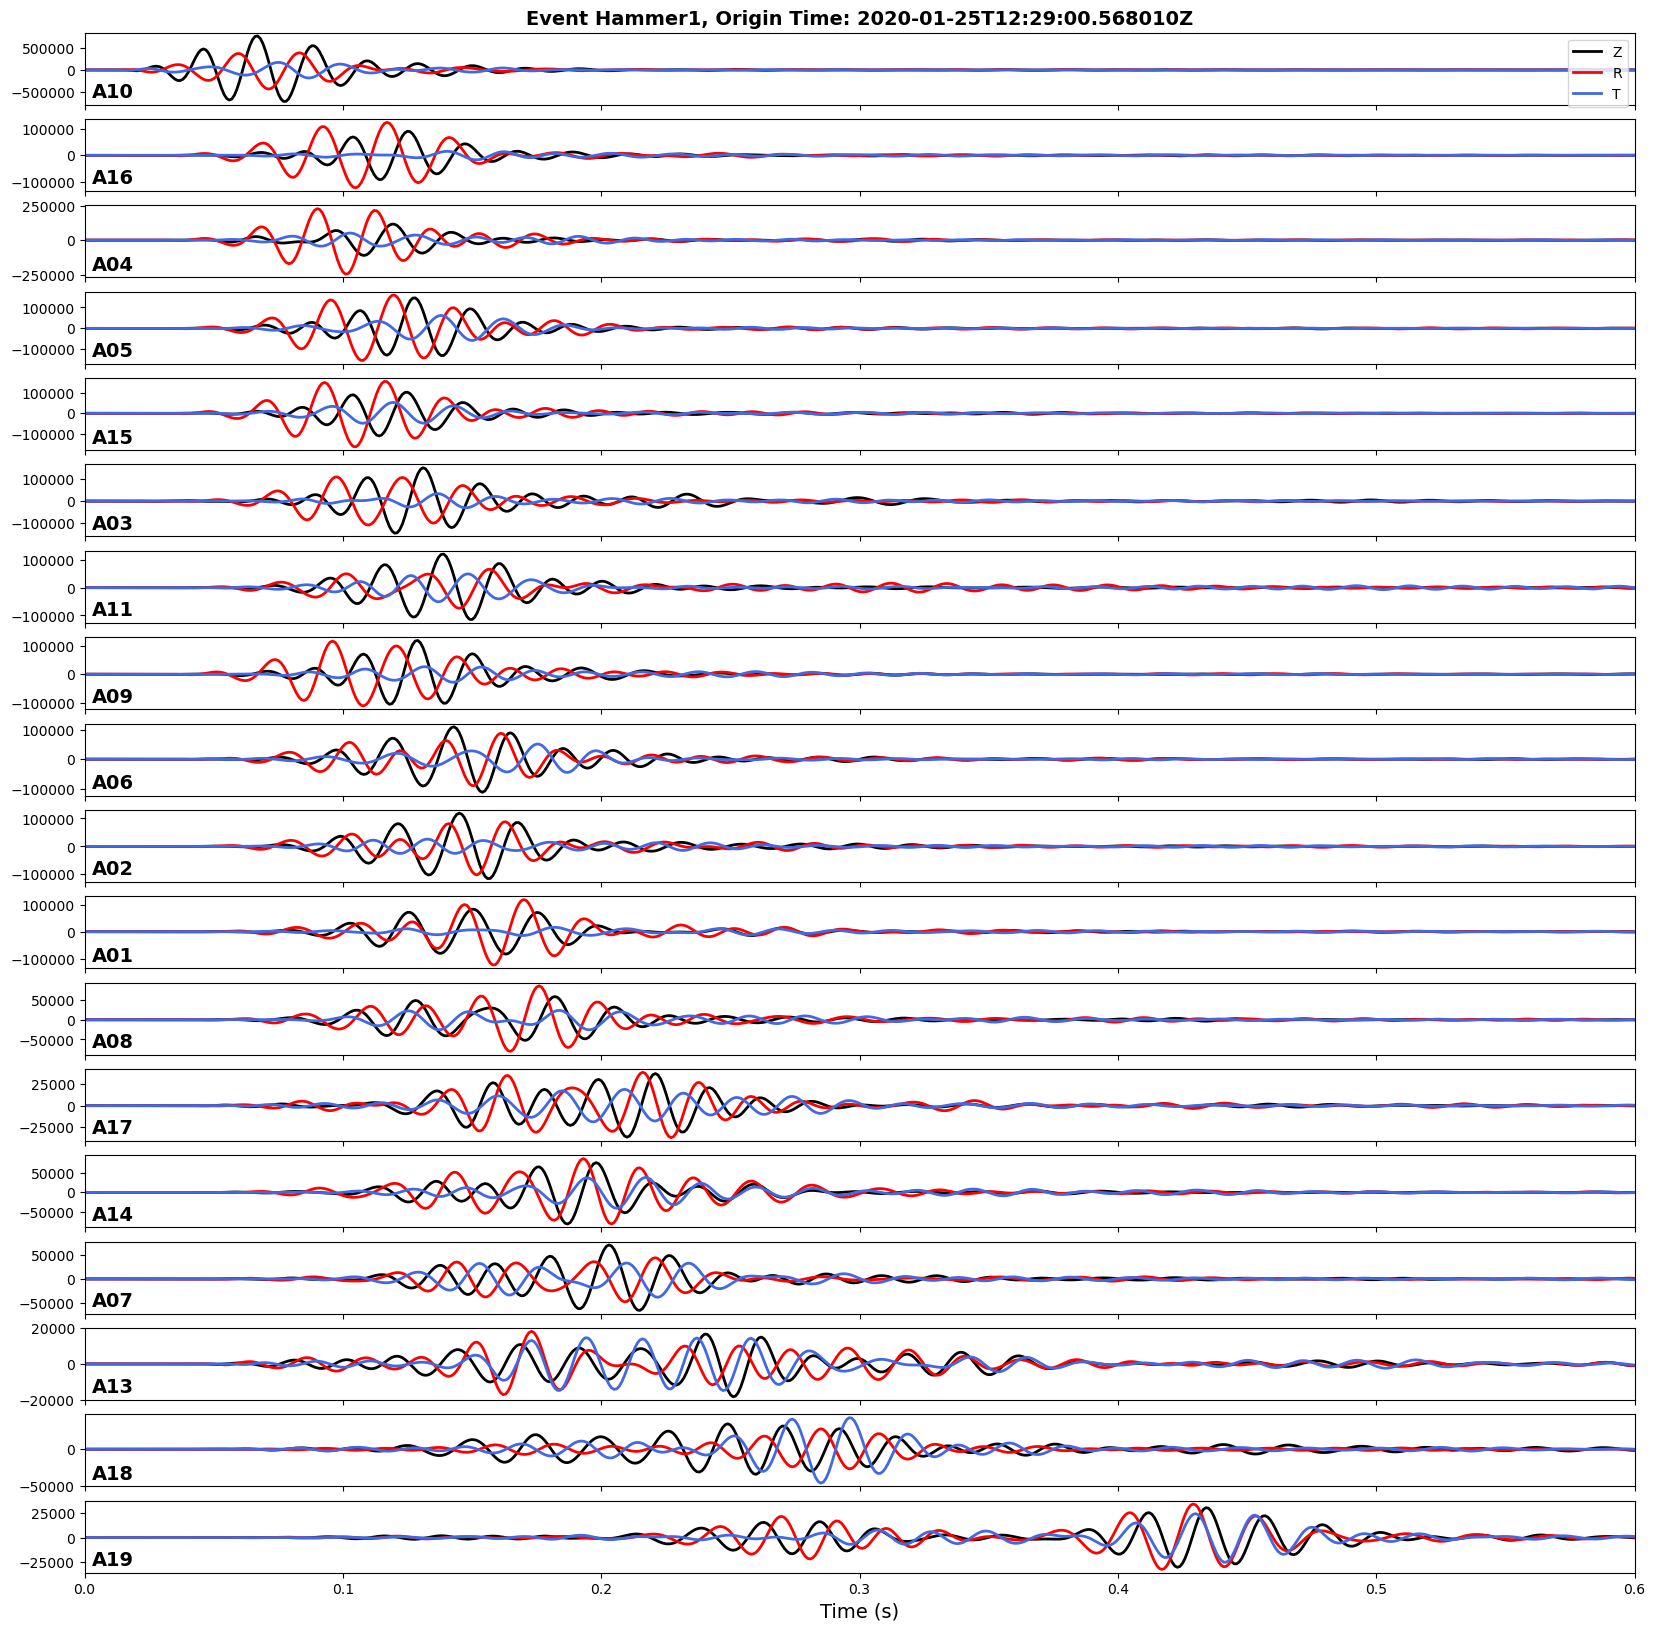

In [29]:


fig, axes = plt.subplots(nrows=numax, ncols=1, sharex=True, figsize=(20, 20))

stind = 0
axind = 0
wavecharac = []
stream_rz = Stream()
while stind < numst:
    row = stadf.iloc[stind]
    stname = row["name"]
    stea = row["easting"]
    stno = row["northing"]
    dist = row["distance"]
    print(f"Processing station {stname} at ({stea}, {stno})")

    # Find the station in the stream
    stream_sta = stream.select(station=stname)

    if stream_sta.count() == 0:
        print(f"Station {stname} not found in the stream")
        stind = stind + 1
        continue
    
    # Trim the stream to the event origin time
    stream_sta.trim(evor+begin, evor+end)

    # Rotate the waveforms
    baz = row["back_azimuth"]
    trace_n = stream_sta.select(channel="GH1")[0]
    trace_e = stream_sta.select(channel="GH2")[0]
    trace_z = stream_sta.select(channel="GHZ")[0]

    # Detrend and taper the data
    trace_n.detrend("linear")
    trace_e.detrend("linear")
    trace_z.detrend("linear")

    trace_n.taper(max_percentage=0.02, type="cosine")
    trace_e.taper(max_percentage=0.02, type="cosine")
    trace_z.taper(max_percentage=0.02, type="cosine")
    
    # Filter the data
    if flag_filter:
        # trace_n.filter("lowpass", freq=cfreq, corners=4, zerophase=False)
        # trace_e.filter("lowpass", freq=cfreq, corners=4, zerophase=False)
        # trace_z.filter("lowpass", freq=cfreq, corners=4, zerophase=False)
        trace_z.filter("bandpass", freqmin=lowfreq, freqmax=highfreq, corners=4, zerophase=False)
        trace_n.filter("bandpass", freqmin=lowfreq, freqmax=highfreq, corners=4, zerophase=False)
        trace_e.filter("bandpass", freqmin=lowfreq, freqmax=highfreq, corners=4, zerophase=False)

    data_n = trace_n.data
    data_e = trace_e.data
    data_z = trace_z.data

    data_r, data_t = rotate_ne_rt(data_n, data_e, baz)

    # Comput the energy ratios between T and Z and T and R
    energy_z = np.sum(data_z**2)
    energy_r = np.sum(data_r**2)
    energy_t = np.sum(data_t**2)

    ratio_tz = energy_t/energy_z
    ratio_tr = energy_t/energy_r

    wavecharac.append({'name': stname, 'distance': dist, 'ratio_tz': ratio_tz, 'ratio_tr': ratio_tr})

    # Save the radial and vertical components
    trace_r = trace_z.copy()
    trace_r.data = data_r
    trace_r.stats.channel = "GHR"

    stream_rz.append(trace_r)
    stream_rz.append(trace_z)

    # Plot the waveforms
    timeax = trace_z.times()
    axes[axind].plot(timeax, data_z, "k", label="Z", linewidth=2)
    axes[axind].plot(timeax, data_r, "r", label="R", linewidth=2)
    axes[axind].plot(timeax, data_t, "royalblue", label="T", linewidth=2)
    axes[axind].annotate(stname, xy=(0.005, 0.1), xycoords="axes fraction", fontsize=14, fontweight="bold")
    axes[axind].set_xlim(timemin, timemax)
    

    if axind == 0:
        axes[axind].legend(loc="upper right", fontsize=10)
        axes[axind].set_title(f"Event {evname}, Origin Time: {evor}", fontsize=14, fontweight="bold")

    if axind == numax-1:
        axes[axind].set_xlabel("Time (s)", fontsize=14)

    stind = stind + 1
    axind = axind + 1

wavecharac = pd.DataFrame(wavecharac)

# Save the waveforms
if flag_filter:
    outpath = join(root, timewin, f"RotatedWaveforms_{evname}_bandpass{lowfreq}_{highfreq}.png")
else:
    outpath = join(root, timewin, f"RotatedWaveforms_{evname}_nofilter.png")

fig.savefig(outpath, dpi=300, bbox_inches="tight", transparent=True)

Station A12 not found in the stream


Text(0, 0.5, 'Log Amplitude')

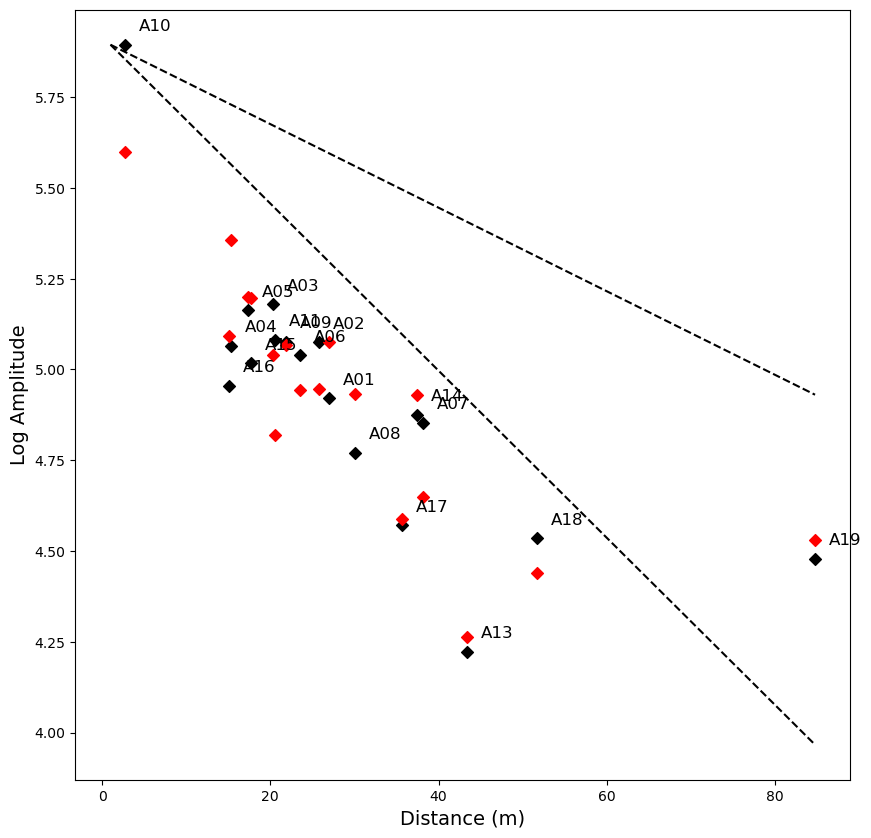

In [50]:
## Compute the maximum amplitude as functions of distance
# Compute the maximum amplitude on the vertical and radial components

stats  = []
dists = []
logamps_z= []
logamps_r = []
for ind, row in stadf.iterrows():
    stname = row["name"]

    
    try:
        trace_z = stream_rz.select(station=stname, component='Z')[0]
        data_z = trace_z.data
        
        trace_r = stream_rz.select(station=stname, component='R')[0]
        data_r = trace_r.data
    except IndexError:
        print(f"Station {stname} not found in the stream")
        continue
    
    stats.append(stname)
    dists.append(row["distance"])
    logamp_z = np.log10(np.max(data_z))
    logamp_r = np.log10(max(data_r))

    logamps_z.append(logamp_z)
    logamps_r.append(logamp_r)

# Plot the maximum amplitude as a function of distance
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(dists, logamps_z, marker="D", color="k", label="Z")

for ind, stname in enumerate(stats):
    ax.annotate(stname, (dists[ind], logamps_z[ind]), xytext=(10, 10), textcoords='offset points', fontsize=12)

ax.scatter(dists, logamps_r, marker="D", color="r", label="R")

## Plot the reference line with slope -1/2
x = np.array([1, np.max(dists)])
y1 = -0.5*np.log10(x)+np.max(logamps_z)
y2 = -1.0*np.log10(x)+np.max(logamps_z)

ax.plot(x, y1, "k--", label=r"$\frac{1}{2}$")
ax.plot(x, y2, "k--", label=r"$1$")
ax.set_xlabel("Distance (m)", fontsize=14)
ax.set_ylabel("Log Amplitude", fontsize=14)


In [ ]:
# # Plot the energy ratios as functions of distance
# fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# axes[0].set_title(f"Event {evname}, Origin Time: {evor}", fontsize=14, fontweight="bold")
# axes[0].stem(wavecharac["distance"], wavecharac["ratio_tr"], basefmt=" ", linefmt="r-", markerfmt="rD")

# for stind, row in wavecharac.iterrows():
#     stname = row["name"]
#     dist = row["distance"]
#     ratio_tr = row["ratio_tr"]

#     axes[0].annotate(stname, xy=(dist, ratio_tr+0.15), xycoords="data", fontsize=10, color="r", rotation=45)
    
# axes[0].axhline(y=1, color="k", linestyle="--")
# axes[0].set_ylim(0, wavecharac["ratio_tr"].max()*1.1)
# axes[0].set_ylabel("T/R ratio", fontsize=14)

# axes[1].stem(wavecharac["distance"], wavecharac["ratio_tz"], basefmt=" ", linefmt="k-", markerfmt="kD")
# axes[1].axhline(y=1, color="k", linestyle="--")
# axes[1].set_ylim(0, wavecharac["ratio_tr"].max()*1.1)
# axes[1].set_ylabel("T/Z ratio", fontsize=14)
# axes[1].set_xlabel("Distance (m)", fontsize=14)

# plt.show() 
# if flag_filter:
#     outpath = join(root, timewin, f"TransverseEnergyRatios_{evname}_bandpass{lowfreq}_{highfreq}.png")
# else:
#     outpath = join(root, timewin, f"TransverseEnergyRatios_{evname}_nofilter.png")

# if flag_filter:
#     outpath = join(root, timewin, f"TransverseEnergyRatios_{evname}_lowpass{cfreq}.png")
# else:
#     outpath = join(root, timewin, f"TransverseEnergyRatios_{evname}_nofilter.png")

  
# fig.savefig(outpath, dpi=300, bbox_inches="tight", transparent=True)


In [ ]:
# # Plot the particle motions for a subset of stations
# %matplotlib notebook

# from animation_utilities import init_particle_motion, update_particle_motion
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# import numpy as np

# stnames_plot = ["A16", "A04", "A05", "A15", "A03", "A06", "A02", "A01", "A08", "A17", "A14"]
# # stname = "A16"
# timemin = 0
# timemax = 0.3

# # Find the station in the stream
# for stname in stnames_plot:
#     print(f"Plotting for {stname}...")

#     ## Find the station in the stream
#     stream_plot = stream_rz.select(station=stname)

#     ## Extract the radial and vertical components
#     trace_r = stream_plot.select(channel="GHR")[0]
#     trace_z = stream_plot.select(channel="GHZ")[0]

#     data_r = trace_r.data
#     data_z = trace_z.data
#     timeax = trace_z.times()

#     data_r = data_r[(timeax >= timemin) & (timeax <= timemax)]
#     data_z = data_z[(timeax >= timemin) & (timeax <= timemax)]
#     timeax = timeax[(timeax >= timemin) & (timeax <= timemax)]

#     maxamp = max(np.abs(data_r).max(), np.abs(data_z).max())
#     data_r = data_r / maxamp
#     data_z = data_z / maxamp

#     # Initialize the plot with empty data
#     fig_ani, ax_pm, ax_wv, dot_r, dot_z, time_text = init_particle_motion(data_r, data_z, timeax, stname)

#     #plt.show()
#     # Create the animation
#     print("Creating the animation...")
#     ani = FuncAnimation(fig_ani, update_particle_motion, 
#                         fargs=(ax_pm, ax_wv, dot_r, dot_z, time_text, data_r, data_z, timeax), 
#                         frames=len(timeax), blit=True, repeat=False, interval=100)

#     # Save the animation
#     print("Saving the animation...")
#     outpath = join(root, timewin, f"ParticleMotion_{evname}_{stname}.mp4")
#     ani.save(outpath, writer='ffmpeg', fps=10, dpi=100)

#     # # Display the animation
#     # print("Displaying the animation...")
#     # HTML(ani.to_html5_video())
